In [16]:
from netCDF4 import Dataset
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
import cartopy.crs as crs
import matplotlib.ticker as mticker
import cartopy.feature as cfeature
from cartopy.feature import NaturalEarthFeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from mpl_toolkits.axes_grid1 import make_axes_locatable
from wrf import getvar, interplevel, to_np, get_basemap, latlon_coords,latlon_coords, smooth2d,get_cartopy, cartopy_xlim, cartopy_ylim
import pandas as pd
import csv
from metpy.plots import SkewT
from metpy.units import pandas_dataframe_to_unit_arrays, units

In [17]:
def u_and_v(wind_direction, wind_speed):
    import math
    degree = ((270-wind_direction)*np.pi/180)
    u = math.cos(degree)*wind_speed
    v = math.sin(degree)*wind_speed
    return (u, v)
def es(T):
    return (610.7*np.exp(((2500800+(4218-1870.4)*273.16)*(1/273.16-1/T)-(4218-1870.4)*np.log(T/273.16))/461.51))

def Td(RH, es):
    e = RH * es
    Td = 1/((1/273.16) - (np.log(e/611)*461/2500000))
    return(Td)

In [36]:
#open the Csv, read it
x = open("Crouch_04Z.csv", "r")

#Deliminate it with commas to grab the observed values
data = csv.reader(x, delimiter =",")
pres_list = []
temp_list = []
dew_list = []
u_ob = []
v_ob = []
ct = 0
pressure=1000
new_pressure = 1000
ct = 0
for line in data:
    if ct != 3:
        if new_pressure > 280 and line[5] != "//" and line[7] != "//":
            new_pressure = float(line[5])
            t = float(line[6])
            RH = float(line[7])* .01
            wind_speed = float(line[8])
            wind_direction = float(line[9])
            u_com, v_com = u_and_v(wind_direction, wind_speed)
            if t < 9800:
                sat_vap = es(t+273.16)
                dew = Td(RH, sat_vap) - 273.16      
            if new_pressure < 9800 and t < 9800 and dew < 9800:
                pres_list.append(new_pressure)
                temp_list.append(t)
                dew_list.append(dew)
                try:
                    u_ob.append(float(u_com))
                    v_ob.append(float(v_com))
                except:
                    i = 3
    ct = ct + 1
    if ct == 3:
        ct = 0
u_ob = np.array(u_ob)
v_ob = np.array(v_ob)

#opening wrf file
name = "NARR_4"
ncfile = Dataset(name)
temp = getvar(ncfile, "tc")
p = getvar(ncfile, "pressure")
temp = interplevel(temp, p, 500)
lon = getvar(ncfile, "lon", meta = False)
lat = getvar(ncfile, "lat", meta = False)

#-115.990, 44.149,

x = 100
y = 200

lons = lon[x,y]
lats = lat[x,y]

In [37]:
#Increase X, Lat Increase, Decrease X, Lat Decrease
x = 318
#Increase Y, Lon Decrease, Decrease Y, Lon Increase
y = 406

#x = 247 y = 385
temp =  getvar(ncfile, "temp", units = "degC", meta = False)
m_list = []

for x in pres_list:
    T_Interp = interplevel(temp, p, x)
    try:
        m_list.append(float(T_Interp[318,406]))
    except:
        z = 0

copy_m_list = m_list
import math
final_model_temp = []
for z in copy_m_list:
        final_model_temp.append(z)
        
temp_list_final = []
for z in temp_list:
    temp_list_final.append(z)
temp_list_final = temp_list[0:3191]

In [ ]:
#Increase X, Lat Increase, Decrease X, Lat Decrease
x = 318
#Increase Y, Lon Decrease, Decrease Y, Lon Increase
y = 406

#x = 247 y = 385
dew =  getvar(ncfile, "td", units = "degC", meta = False)
dew_m_list = []

for x in pres_list:
    D_Interp = interplevel(dew, p, x)
    try:
        dew_m_list.append(float(D_Interp[318,406]))
    except:
        z = 0

In [38]:
new_t = []
m_t = []
ct = 0
for x in pres_list:
    if x > 575 and x < 780:
        new_t.append(temp_list[ct])
        m_t.append(m_list[ct])
    ct = ct + 1
        
        

In [39]:
ct = 0
difference_list = []
flag = True
while ct < len(m_t):
    difference_list.append((m_t[ct] - new_t[ct])**2)
    ct = ct + 1
r_sum = sum(difference_list)
RMSE = (r_sum/ct)**(1/2)
print(RMSE)

1.0757220262519904


In [14]:
len(new_t)

575

In [12]:
u_m = getvar(ncfile, "ua", units = "m s-1", meta = False)
v_m = getvar(ncfile, "va", units = "m s-1", meta = False)
u_m_list = []
v_m_list = []
for x in pres_list:
    U_Interp = interplevel(u_m, p, x)
    V_Interp = interplevel(v_m, p, x)
    try:
        u_m_list.append(float(U_Interp[318,406]))
        v_m_list.append(float(V_Interp[318,406]))
    except:
        z = 0

2.5803685234189535


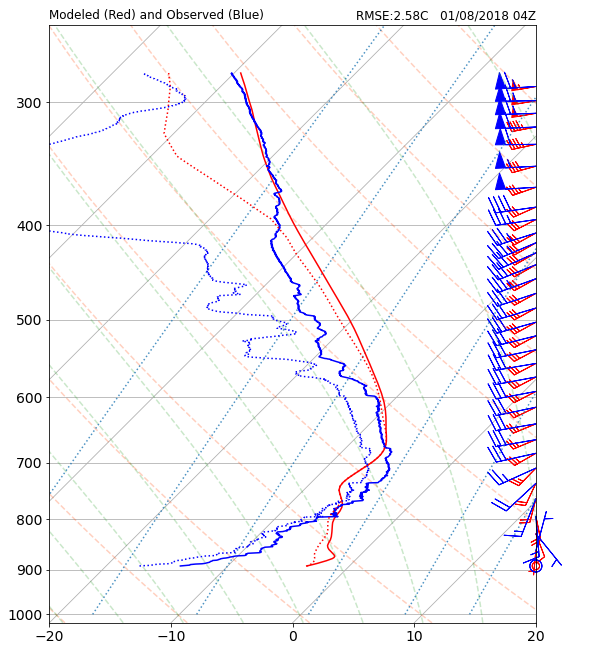

In [13]:
u = np.array(u_m_list)
v = np.array(v_m_list)
# Change default to be better for skew-T
fig = plt.figure(figsize=(9, 11))

# Initiate the skew-T plot type from MetPy class loaded earlier
skew = SkewT(fig, rotation=45)

# Plot the data using normal plotting functions, in this case using
# log scaling in Y, as dictated by the typical meteorological plot
skew.plot(np.array(pres_list), np.array(m_list), 'red')
skew.plot(np.array(pres_list), np.array(temp_list), 'blue')
skew.plot(np.array(pres_list), np.array(dew_m_list), 'red', linestyle = "dotted")
skew.plot(np.array(pres_list), np.array(dew_list), 'blue', linestyle = "dotted")
#skew.plot(pres_list, Td, 'g')
skew.plot_barbs(pres_list[::50][0:50], u[::50][0:50], v[::50][0:50], y_clip_radius=0.03, color = "red",length = 7)
skew.plot_barbs(pres_list[::50][0:50], u_ob[::50][0:50], v_ob[::50][0:50], y_clip_radius=0.03, color = "blue", length = 9)

# Set some appropriate axes limits for x and y
skew.ax.set_xlim(-20, 20)
skew.ax.set_ylim(1020, 250)
skew.ax.xaxis.set_tick_params(labelsize = 14)
skew.ax.yaxis.set_tick_params(labelsize = 14)
#plt.xlabel("°C", size = 15)
#plt.ylabel("hPa", size = 15)

# Add the relevant special lines to plot throughout the figure
skew.plot_dry_adiabats(t0=np.arange(233, 533, 10) * units.K,
                       alpha=0.25, color='orangered')
skew.plot_moist_adiabats(t0=np.arange(233, 400, 5) * units.K,
                         alpha=0.25, color='tab:green')
skew.plot_mixing_lines(p=np.arange(1000, 99, -20) * units.hPa,
                       linestyle='dotted', color='tab:blue')
ct = 0
difference_list = []
for m_t in m_list:
    m_t = str(m_t)
    if m_t != 'nan':
        m_t = float(m_t)
        difference_list.append((m_t - temp_list[ct])**2)
        ct = ct + 1
r_sum = sum(difference_list)
RMSE = (r_sum/ct)**(1/2)
print(RMSE)

#Add RMSE
rmse_text = "RMSE:"+ str(RMSE)[0:4] + 'C   01/08/2018 04Z'
# Add some descriptive titles
plt.title('Modeled (Red) and Observed (Blue)', loc='left', size = 12)
#plt.title('Modeled Crouch Sounding', loc='left', size = 13)
plt.title(rmse_text, loc='right', size = 12)

plt.show()
#fig.savefig("Model_and_Observed_Sounding_08_11Z_Boise.png")
fig.savefig("NARR_04_Sounding")

NameError: name 'difference' is not defined

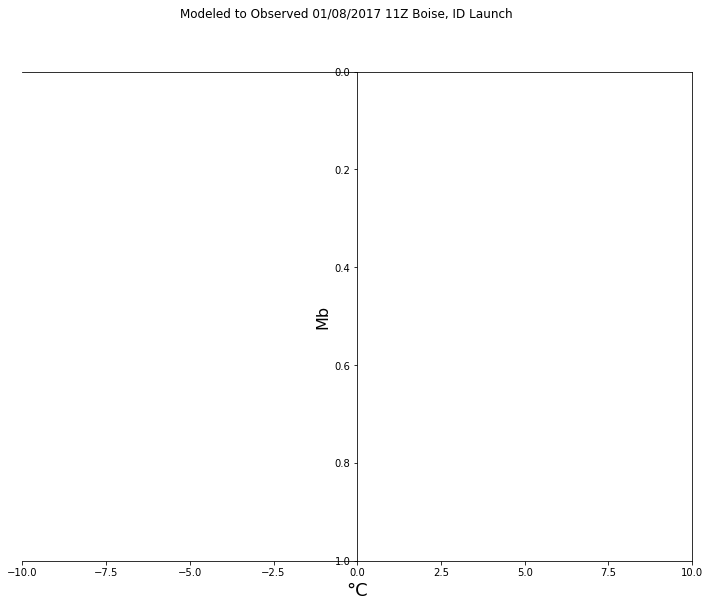

In [9]:
import matplotlib.pyplot as plt
import numpy as np

py = np.array(pres_list[0:3191])
fig = plt.figure(figsize=(12,9))
ax = plt.gca()
ax.spines['left'].set_position('zero')

plt.gca().invert_yaxis()
plt.suptitle('Modeled to Observed 01/08/2017 11Z Boise, ID Launch', fontsize=12)
plt.xlabel('°C', fontsize=18)
plt.ylabel('Mb', fontsize=16)
plt.xlim([-10,10])
plt.plot(difference, py)
plt.show()
fig.savefig("Modeled_Obs_Boise_Sounding_0108201711Z.png")